# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

According to [statista](https://www.statista.com/topics/9879/used-vehicles-in-the-united-states/#topicOverview) there is a USD 138.1 bn used car dealer market size in the US. The used car vehicle sales amount to USD 38.6M with an average selling price of \$30.7K per vehicle. Effective pricing and stocking strategies can help any used car dealership to sell effectively and maximize profits.

Here I would like to use supervised machine learning methods to be able to model the price of used cars and attempt to evaluate the features that most contributes to the price of the car. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy import stats
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

from sklearn import set_config

set_config(display="diagram") #setting this will display your pipelines as seen above
warnings.filterwarnings("ignore")

In [2]:
car = pd.read_csv('data/vehicles.csv')

In [3]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
car.corr(numeric_only=True)

id     price      year  odometer
id        1.000000 -0.002779 -0.059040  0.010721
price    -0.002779  1.000000 -0.004925  0.010032
year     -0.059040 -0.004925  1.000000 -0.157215
odometer  0.010721  0.010032 -0.157215  1.000000

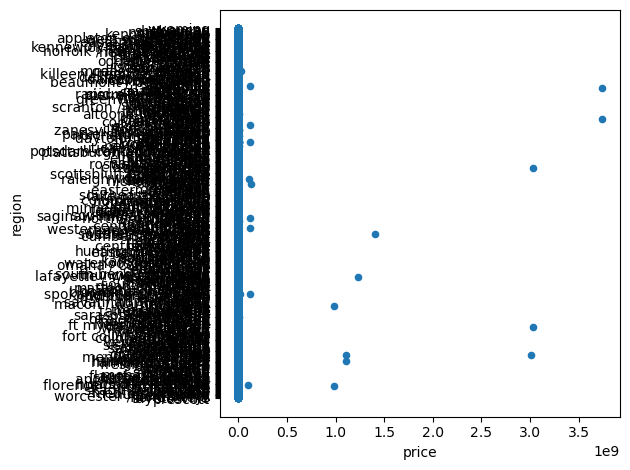

In [5]:
car.plot.scatter('price', 'region')
plt.tight_layout()
plt.savefig('images/price-scatter')
plt.show('jpg')

#### It is clear that there are outliers in the data. Lets see how the histogram of the log will look like

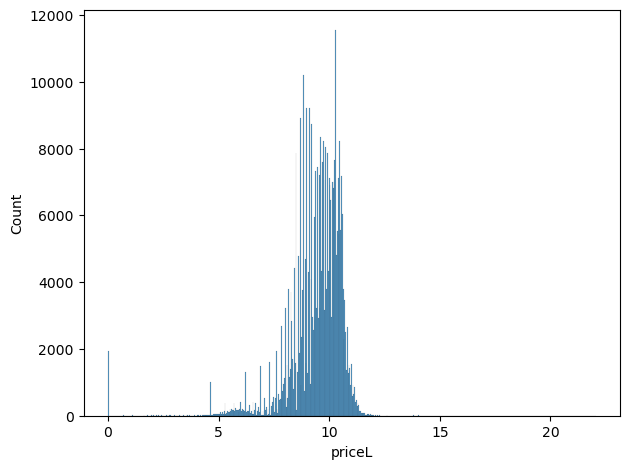

In [6]:
car[ 'priceL' ] = np.log( car['price'] )
sns.histplot(data=car, x='priceL')
plt.tight_layout()
plt.savefig('images/priceL-hist')
#plt.show('jpg')

#### Eliminate outlier data in car price.
Find out the lowest price that would cover 99% of the data and only retain that.

In [7]:
i = 1000
while(True):
    p = len(car[car['price']<i])/len(car)
    if p >= 0.99:
        break
    i += 5000
print( i )

71000


In [8]:
car = car[car['price']<=i]

In [9]:
car.describe()

id          price           year      odometer        priceL
count  4.238090e+05  423809.000000  422685.000000  4.194440e+05  4.238090e+05
mean   7.311484e+09   16910.090829    2011.218312  9.847036e+04          -inf
std    4.473470e+06   14049.185932       9.403487  2.138788e+05           NaN
min    7.207408e+09       0.000000    1900.000000  0.000000e+00          -inf
25%    7.308142e+09    5900.000000    2008.000000  3.844575e+04  8.682708e+00
50%    7.312614e+09   13800.000000    2013.000000  8.605400e+04  9.532424e+00
75%    7.315252e+09   25990.000000    2017.000000  1.340000e+05  1.016547e+01
max    7.317101e+09   71000.000000    2022.000000  1.000000e+07  1.117044e+01

#### Observation: 
- Maximum sales happens for the lower priced cars. The 75th percentile is at $25990
- The average odometer reading is about 98000 miles

#### Now lets explore the data a bit with various histogram plots.

#### Create a date column to help plot

In [10]:
car['date'] = pd.to_datetime(car['year'], format='%Y')

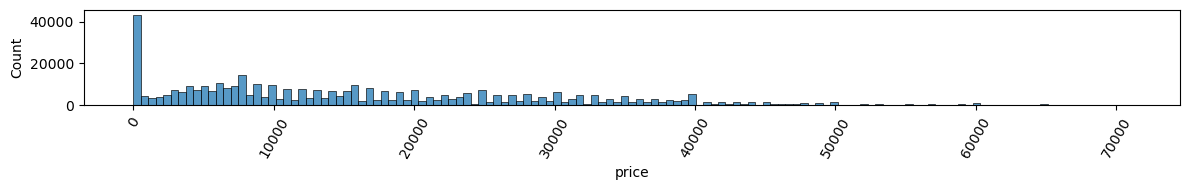

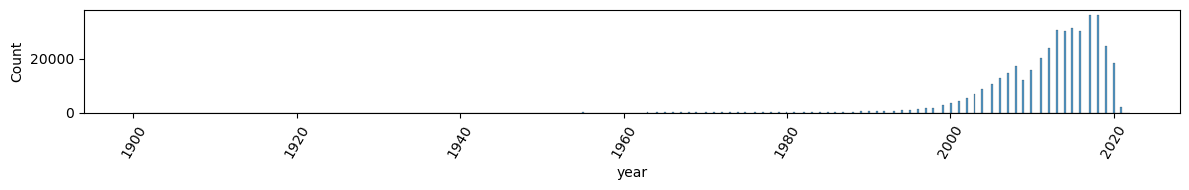

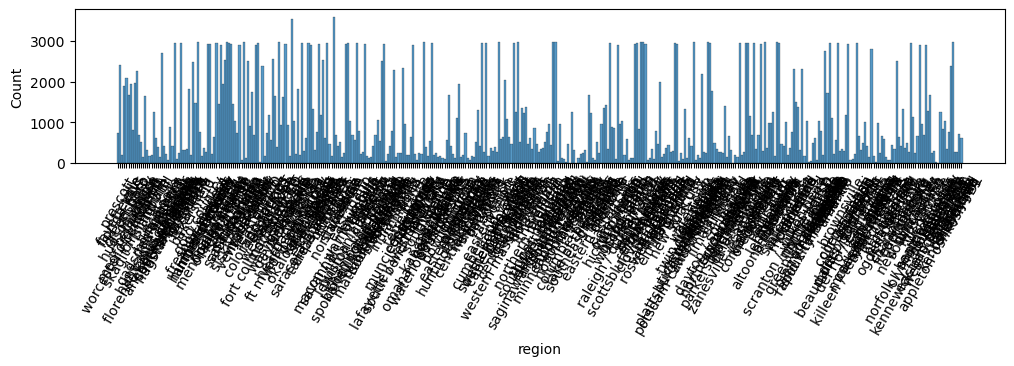

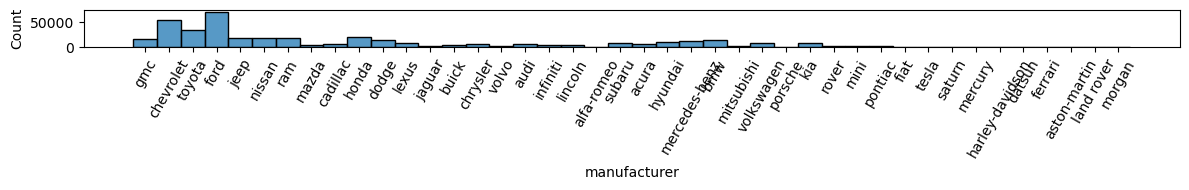

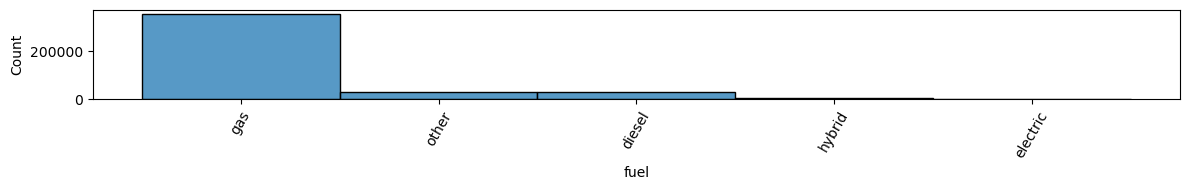

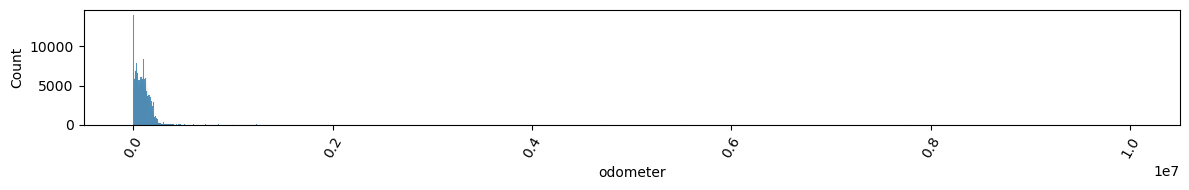

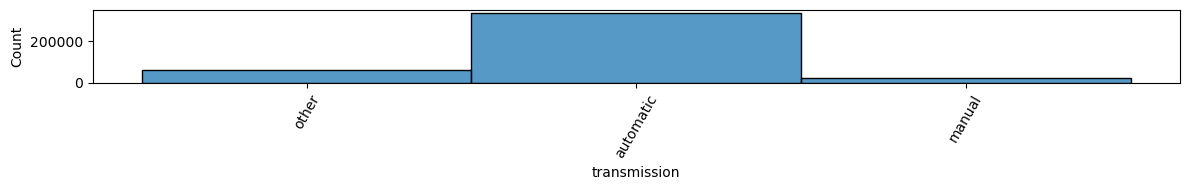

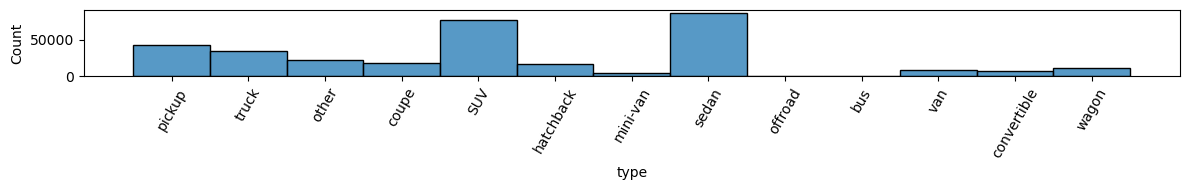

In [11]:
def plotHist(df, xarg, imageName):
    fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(12,2))
    sns.histplot(data=df, x=xarg, ax=axes)
    plt.xticks(rotation = 60)
    plt.tight_layout()
    plt.savefig('images/' + imageName)
    plt.show('jpg')
    
plotHist(car, 'price', 'price-hist')
plotHist(car, 'year', 'year-hist')
plotHist(car, 'region', 'region-hist')
plotHist(car, 'manufacturer', 'manu-hist')
plotHist(car, 'fuel', 'fuel-hist')
plotHist(car, 'odometer', 'odo-hist')
plotHist(car, 'transmission', 'tran-hist')
plotHist(car, 'type', 'type-hist')

#### Observation
- There is more sales on newer cars. This may be due to higher inventory of such cars
- There are no clear patterns for regions. Certain regions have more sale than others.
- Ford, Toyota and chevrolet are popular manufacturers
- Gas cars are more popular than other types
- Lower odometer cars are more preferred
- Automatic transmission seems to be the preferred choice
- Sedans, SUV, followed by pickups have the highest sale over other types.

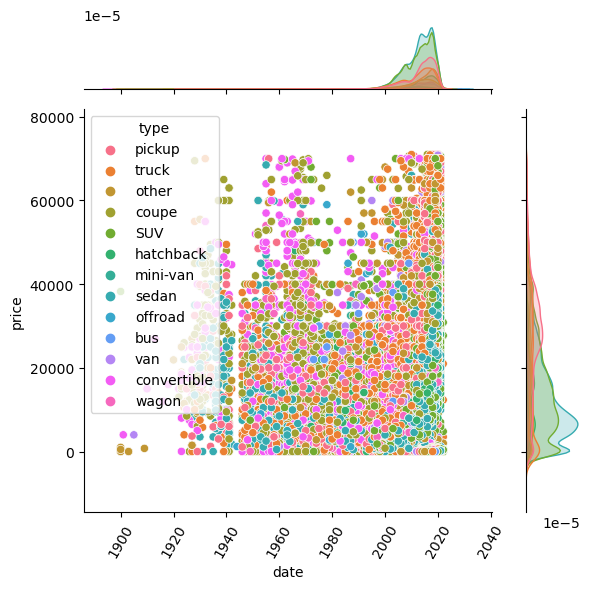

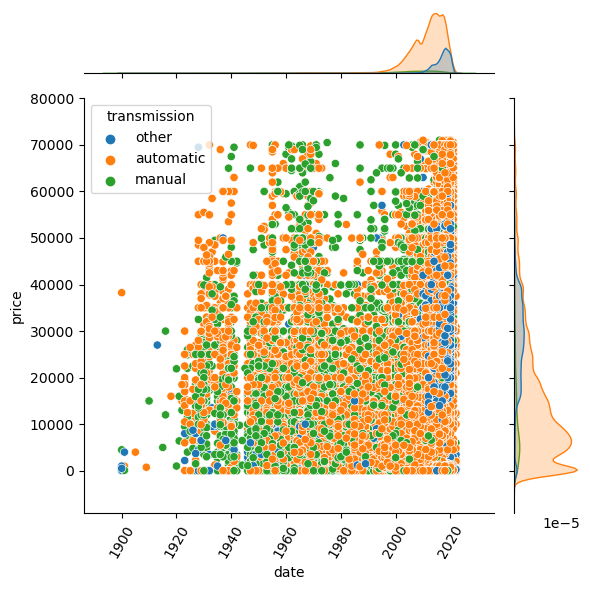

In [12]:
#px.scatter(car, x='date', y='price', color='type', marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")
#px.scatter(car, x='date', y='price', color='transmission', marginal_y="violin", marginal_x="box", trendline="ols", template="simple_white")

def plotJoint(df, xarg, yarg, huearg, imageName):
    sns.jointplot(data=df, x=xarg, y=yarg, hue=huearg)
    plt.xticks(rotation = 60)
    plt.tight_layout()
    plt.savefig('images/' + imageName)
    plt.show('jpg')

plotJoint(car, 'date', 'price', 'type', 'date-price-type-joint')
plotJoint(car, 'date', 'price', 'transmission', 'date-price-trans-joint')

#### Observation
- Among the newer cars the 'other' type appears to be the dominant type. 
- Among the newer cars, the pickups and trucks seem be higher priced

#### Observation
- Manual transmission seems be the majority of the sales
- Manual transmission has a lower average price than Automatic transmission at all times.

#### Lets look at some recent trends (in the last 10 years)

In [13]:
recentCar = car[car['date'] > '01-01-2010'].sort_values('date')

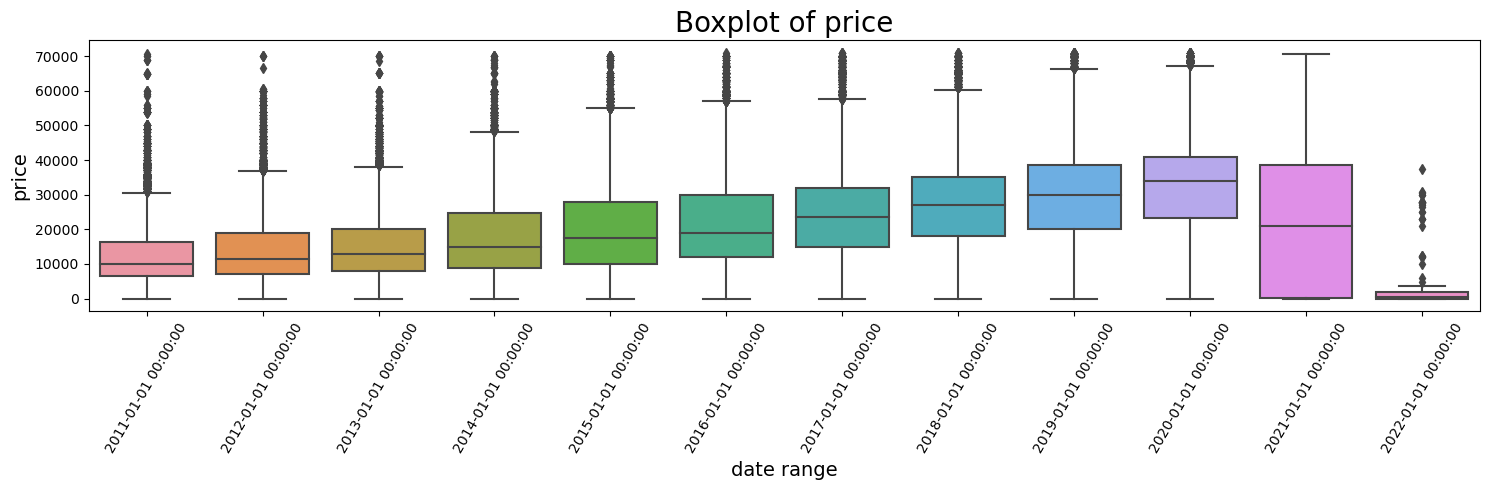

In [14]:
plt.figure(figsize=(15,5))
xprop = 'date'
yprop = 'price'
sns.boxplot(data=recentCar, x=xprop, y=yprop)
plt.xlabel('{} range'.format(xprop), size=14)
plt.ylabel('{}'.format(yprop), size=14)
plt.title('Boxplot of {}'.format(yprop), size=20)
plt.xticks(rotation = 60)
plt.tight_layout()
plt.savefig('images/price-box')
plt.show('jpg')

####Observation
- The median price of newer cars are in general higher. There is some anamoly for 2022 year cars.


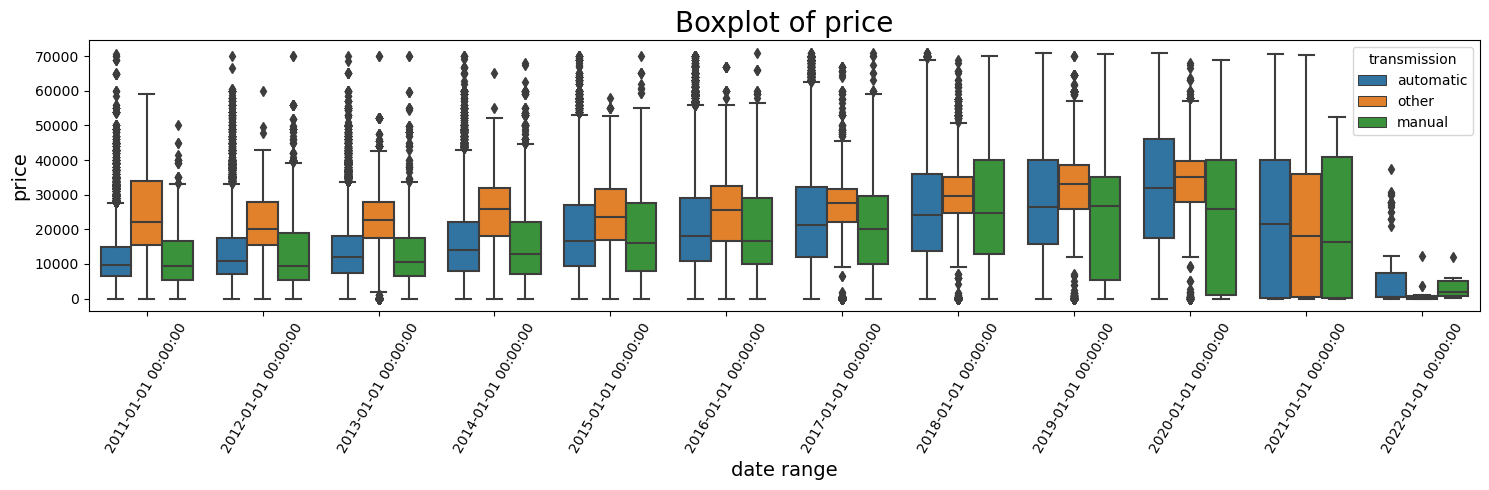

In [15]:
plt.figure(figsize=(15,5))
xprop = 'date'
yprop = 'price'
sns.boxplot(data=recentCar, x=xprop, y=yprop, hue='transmission')
plt.xlabel('{} range'.format(xprop), size=14)
plt.ylabel('{}'.format(yprop), size=14)
plt.title('Boxplot of {}'.format(yprop), size=20)
plt.xticks(rotation = 60)
plt.tight_layout()
plt.savefig('images/transmission-price-box')
plt.show('jpg')

#### Observation
There is a larger variation in the price for newer cars

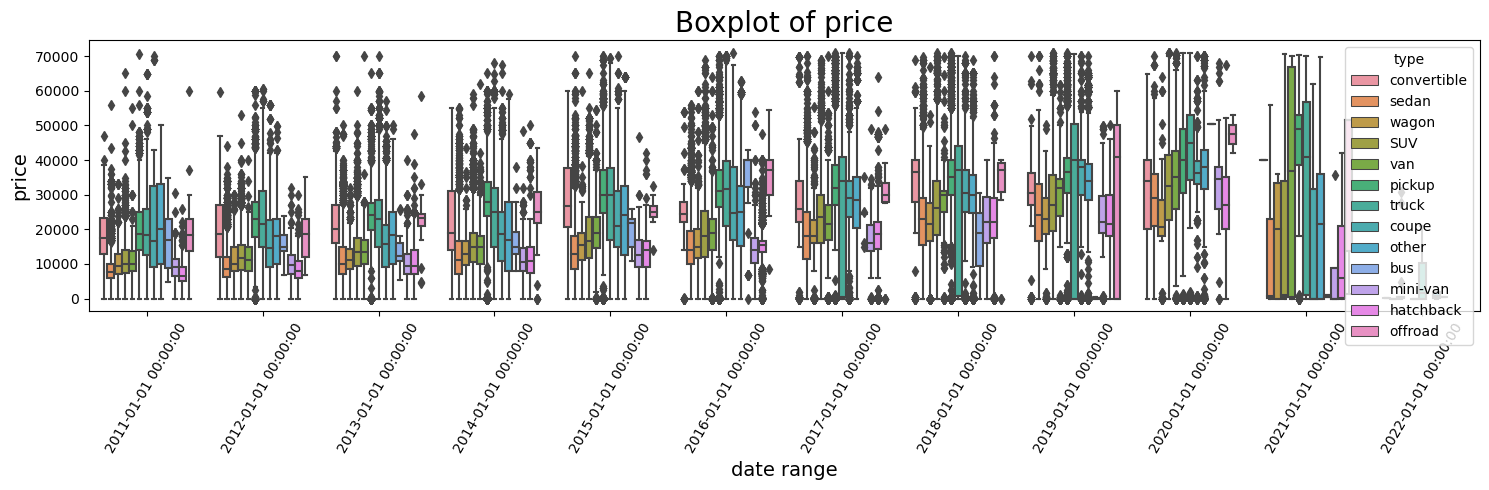

In [16]:
plt.figure(figsize=(15,5))
xprop = 'date'
yprop = 'price'
sns.boxplot(data=recentCar, x=xprop, y=yprop, hue='type')
plt.xlabel('{} range'.format(xprop), size=14)
plt.ylabel('{}'.format(yprop), size=14)
plt.title('Boxplot of {}'.format(yprop), size=20)
plt.xticks(rotation = 60)
plt.tight_layout()
plt.savefig('images/type-price-box')
plt.show('jpg')

#### Observation
- Van and pickup pricess are higher in general than other types

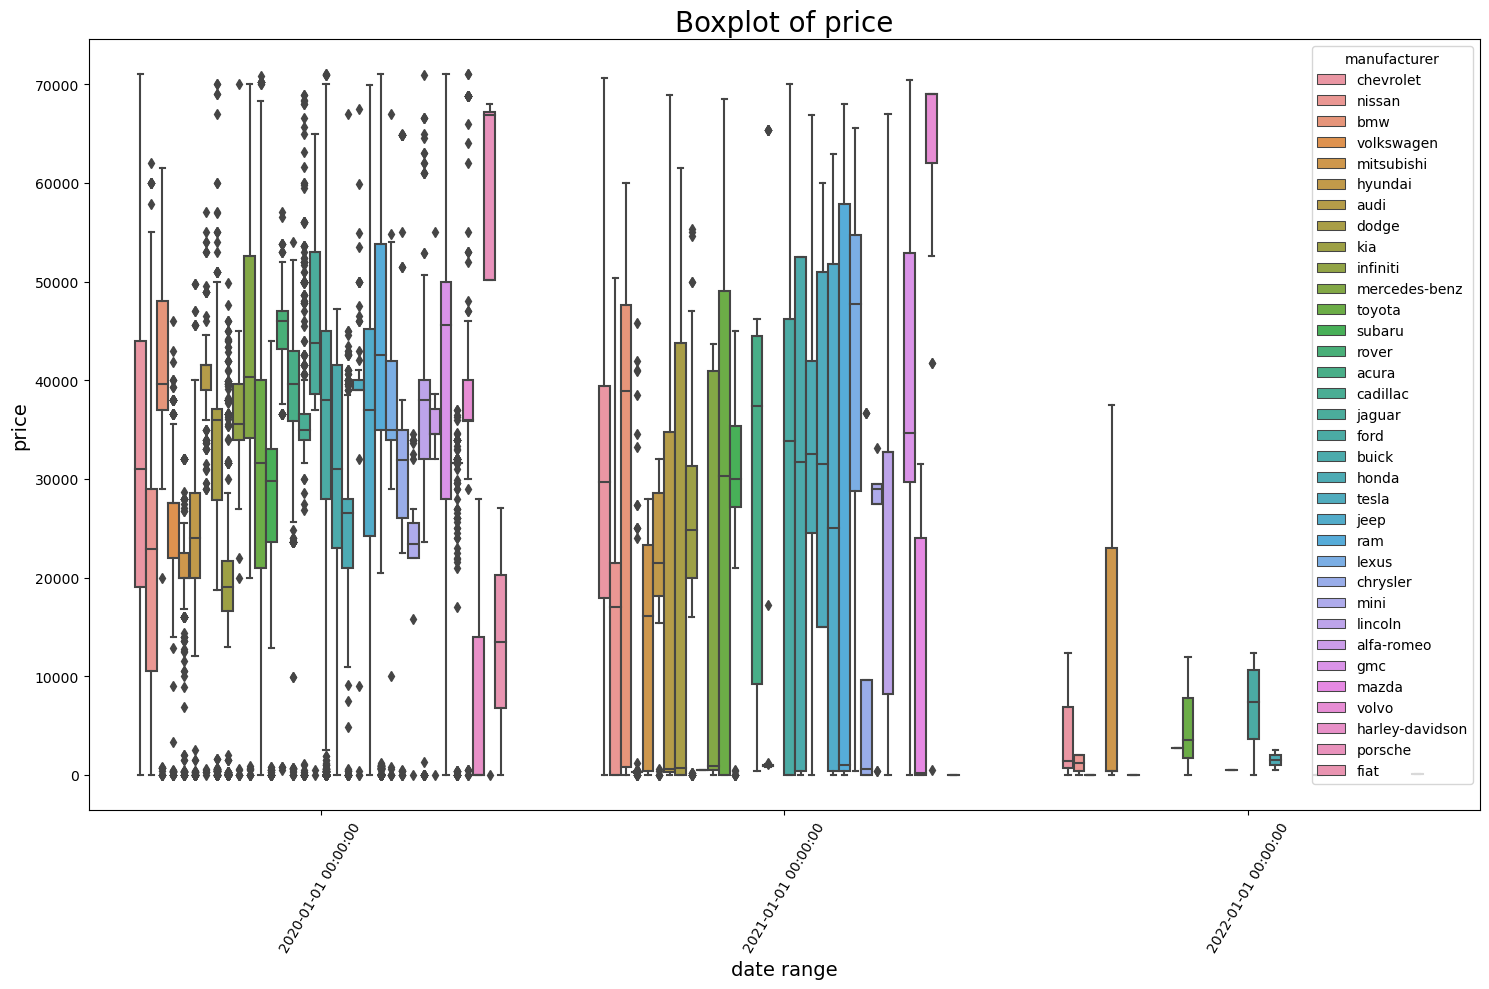

In [17]:
recentCar1 = car[car['date'] > '01-01-2019'].sort_values('date')
plt.figure(figsize=(15,10))
xprop = 'date'
yprop = 'price'
sns.boxplot(data=recentCar1, x=xprop, y=yprop, hue='manufacturer')
plt.xlabel('{} range'.format(xprop), size=14)
plt.ylabel('{}'.format(yprop), size=14)
plt.title('Boxplot of {}'.format(yprop), size=20)
plt.xticks(rotation = 60)
plt.tight_layout()
plt.savefig('images/manu-price-box')
plt.show('jpg')

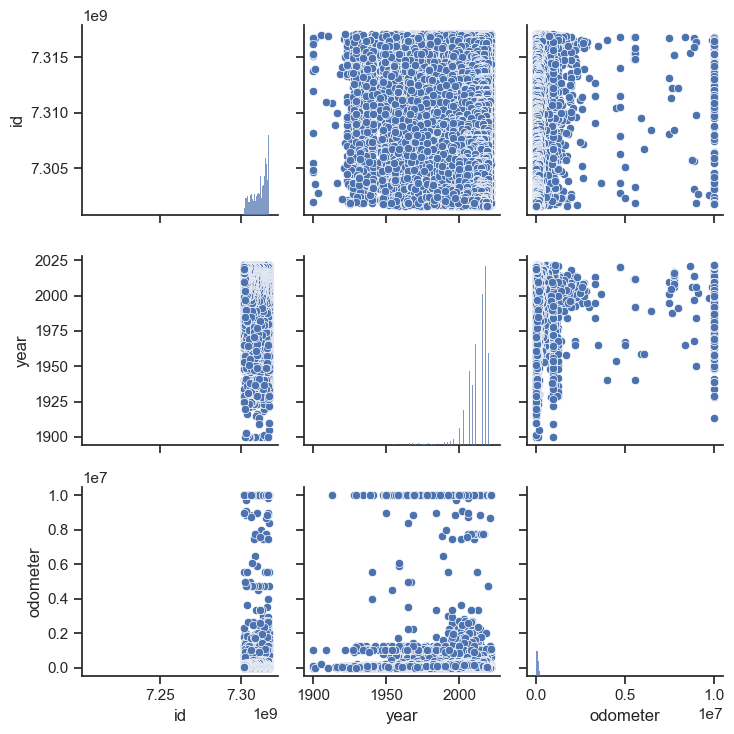

In [18]:
df = car.drop( 'price', axis=1 ).drop( 'priceL', axis=1 ).drop( 'date', axis=1 )
sns.set_theme( style="ticks" )
sns.pairplot(df)
plt.tight_layout()
plt.savefig('images/pairplot')
plt.show('jpg')

In [19]:
car.isna().sum()

id                   0
region               0
price                0
year              1124
manufacturer     17236
model             5083
condition       172075
cylinders       176208
fuel              2999
odometer          4365
title_status      8167
transmission      2544
VIN             160107
drive           129848
size            303924
type             92207
paint_color     129201
state                0
priceL               0
date              1124
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Lets drop the columns id, VIN and state.

In [20]:
car = car.drop( 'id', axis=1 ).drop( 'VIN', axis=1 ).drop( 'state', axis=1 )

#### Lets take a look at NA value

#### Drop condition, cylinders and size.
40% of cylinders data and 41% of condition data is NaN
71% of size data is missing

In [21]:
car = car.drop( 'cylinders', axis=1 ).drop( 'condition', axis=1 ).drop( 'size', axis=1 ).\
          drop( 'drive', axis=1 ).drop( 'paint_color', axis=1 ).drop( 'title_status', axis=1 )

In [22]:
car.isna().sum()

region              0
price               0
year             1124
manufacturer    17236
model            5083
fuel             2999
odometer         4365
transmission     2544
type            92207
priceL              0
date             1124
dtype: int64

#### Look at rest of the NaN values
The rest of the features are important to the model. It is not useful to impute data in this case. It is better to simply drop the rows that have these NaN values as the overall percentage seems low.

In [23]:
def dropNaColumns( cols, df ):
    for col in cols:
        df = df[ df[ col ].notna() ]
    return df
        
cols = [ 'manufacturer', 'model', 'fuel', 'odometer', 'transmission', 'type', 'year' ]
car = dropNaColumns( cols, car )
car.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
fuel            0
odometer        0
transmission    0
type            0
priceL          0
date            0
dtype: int64

In [24]:
car.corr(numeric_only=True)

price      year  odometer    priceL
price     1.000000  0.359939 -0.197951  0.771401
year      0.359939  1.000000 -0.210837  0.331607
odometer -0.197951 -0.210837  1.000000 -0.190807
priceL    0.771401  0.331607 -0.190807  1.000000

In [25]:
car.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311499 entries, 27 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   region        311499 non-null  object        
 1   price         311499 non-null  int64         
 2   year          311499 non-null  float64       
 3   manufacturer  311499 non-null  object        
 4   model         311499 non-null  object        
 5   fuel          311499 non-null  object        
 6   odometer      311499 non-null  float64       
 7   transmission  311499 non-null  object        
 8   type          311499 non-null  object        
 9   priceL        311499 non-null  float64       
 10  date          311499 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 28.5+ MB


In [26]:
car = car.drop([ 'region', 'model', 'priceL' ], axis=1 )
car = pd.get_dummies(car, dtype=int, columns=['manufacturer', 'fuel', 'transmission', 'type'])

In [27]:
y = car['price']
X = car.drop(['price', 'date'], axis=1)

#### The number of features are very high. But since our ultimage goal is to understand what factors/features drive up or down the cost, it is better not to perform a PCA. This is because PCA would remove our ability to explain how the target moves with respect to the input features. It makes inference harder.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Lets split the data into training and testing set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Lets attempt a simple Linear regression first

In [29]:
model = LinearRegression()
model.fit( X_train, y_train )
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)
train_mse, test_mse, r2_train, r2_test

(119918160.71220581,
 120247164.59735604,
 0.37970424618253873,
 0.3782493672729581)

#### Scores for Linear Regression

 - MSE Train = 119918160.71220581
 - MSE Test  = 120247164.59735604
 - R2 Train  = 0.37970424618253873
 - R2 Train  = 0.3782493672729581

This indicates that the fit is not that great

#### Lets try a Ridge and GridSearch the hyper parameters. 
#### But since we have a lot of columns, it is better to avoid PolynomialFeatures

In [30]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), ['year', 'odometer'])],
    remainder='passthrough'
)

pipe = Pipeline([('prep', preprocessor),    
                 ('ridge', Ridge())
                ])
pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('ridge', Ridge())])

In [31]:
from random import shuffle, seed
all_indices = list(range(0, len(car)))
seed(42)
shuffle(all_indices)
train_idx, test_idx = np.split(all_indices, [len(X_train)])
train_idx.shape, test_idx.shape

((218049,), (93450,))

In [32]:
param_dict = {
              'ridge__alpha': np.logspace(0, 5, 50),
             }
ridge_grid = GridSearchCV(pipe, param_grid=param_dict, scoring='neg_mean_squared_error', cv=[[train_idx, test_idx]])
ridge_grid.fit(X, y)

ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

In [33]:
ridge_train_mse, ridge_test_mse

(119938066.0087205, 120119560.2995357)

In [34]:
ridge_grid.best_params_

{'ridge__alpha': 1.0}

In [35]:
best_estimator = ridge_grid.best_estimator_
ridge_r2_train = best_estimator.score(X_train, y_train)
ridge_r2_test = best_estimator.score(X_test, y_test)
ridge_r2_train, ridge_r2_test

(0.3796012828712837, 0.37890915873809705)

#### Scores for Ridge Regression

 - MSE Train = 119938066.0087205
 - MSE Test  = 120119560.2995357
 - R2 Train  = 0.3796012828712837
 - R2 Train  = 0.37890915873809705
 
 The alpha value of 1.0 was the best in the GridSearch

This indicates that the fit is not that great for Ridge either. I think the quality of the input data may not be that great.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Lets get an idea about the Permuation importance of the various features

In [36]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_estimator, X, y,
                           n_repeats=30,
                           random_state=0)

In [37]:
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{X.columns[i] : <12}"
               f"{r.importances_mean[i] : .3f}"
               f" +/- {r.importances_std[i] : .3f}")

year         0.177 +/-  0.001
type_sedan   0.058 +/-  0.000
type_pickup  0.048 +/-  0.000
transmission_other 0.032 +/-  0.000
type_truck   0.021 +/-  0.000
transmission_automatic 0.020 +/-  0.000
odometer     0.019 +/-  0.000
type_hatchback 0.015 +/-  0.000
fuel_diesel  0.015 +/-  0.000
manufacturer_nissan 0.010 +/-  0.000
type_SUV     0.009 +/-  0.000
manufacturer_tesla 0.006 +/-  0.000
manufacturer_honda 0.006 +/-  0.000
type_wagon   0.006 +/-  0.000
manufacturer_kia 0.006 +/-  0.000
manufacturer_hyundai 0.006 +/-  0.000
manufacturer_audi 0.005 +/-  0.000
type_coupe   0.004 +/-  0.000
manufacturer_lexus 0.004 +/-  0.000
manufacturer_volkswagen 0.004 +/-  0.000
fuel_gas     0.003 +/-  0.000
manufacturer_ford 0.003 +/-  0.000
manufacturer_porsche 0.003 +/-  0.000
manufacturer_mitsubishi 0.003 +/-  0.000
manufacturer_mazda 0.003 +/-  0.000
type_mini-van 0.003 +/-  0.000
type_convertible 0.002 +/-  0.000
manufacturer_rover 0.002 +/-  0.000
manufacturer_dodge 0.002 +/-  0.000
manufacturer

#### The following features most contribute to the fitted model (in this order) 
- year         0.177 +/-  0.001
- type_sedan   0.058 +/-  0.000
- type_pickup  0.048 +/-  0.000
- transmission_other 0.032 +/-  0.000
- type_truck   0.021 +/-  0.000
- transmission_automatic 0.020 +/-  0.000
- odometer     0.019 +/-  0.000

#### But lets look at the coefficients of the best estimator as determined by Grid search

In [38]:
features_df = pd.DataFrame()
features_df[ 'feature' ] = X.columns
features_df[ 'coef' ] = best_estimator.get_params()['ridge'].coef_
features_df = features_df.sort_values( 'coef' )
features_df

feature          coef
13          manufacturer_ferrari -11181.170084
17  manufacturer_harley-davidson  -7624.750477
14             manufacturer_fiat  -7609.871408
37           manufacturer_saturn  -6466.810539
55                type_hatchback  -5616.942249
..                           ...           ...
59                   type_pickup   6358.156594
36            manufacturer_rover   6736.695470
34          manufacturer_porsche  10007.805848
11           manufacturer_datsun  13633.421026
39            manufacturer_tesla  16103.038489

[64 rows x 2 columns]

In [39]:
lr_features_df = pd.DataFrame()
lr_features_df[ 'feature' ] = X.columns
lr_features_df[ 'coef' ] = model.coef_
lr_features_df = features_df.sort_values( 'coef' )
lr_features_df

feature          coef
13          manufacturer_ferrari -11181.170084
17  manufacturer_harley-davidson  -7624.750477
14             manufacturer_fiat  -7609.871408
37           manufacturer_saturn  -6466.810539
55                type_hatchback  -5616.942249
..                           ...           ...
59                   type_pickup   6358.156594
36            manufacturer_rover   6736.695470
34          manufacturer_porsche  10007.805848
11           manufacturer_datsun  13633.421026
39            manufacturer_tesla  16103.038489

[64 rows x 2 columns]

#### Observation 
- The coefficients with the highest negative value is the following. This indicates decrease in price for one unit change in the predictor, while holding others constant

  * Manufacturer ferrari
  * Manufacturer Harley Davidson
  * Manufacturer Fiat
  * Manufaccturer Saturn
  
- The coefficients indicate that the following predictors drive price up (in the order listed below)

  * Manufacturer Tesla
  * Manufacturer Datsun
  * Manufacturer Porsche
  * Manufacturer Rover
  * Type Pickup
  
  

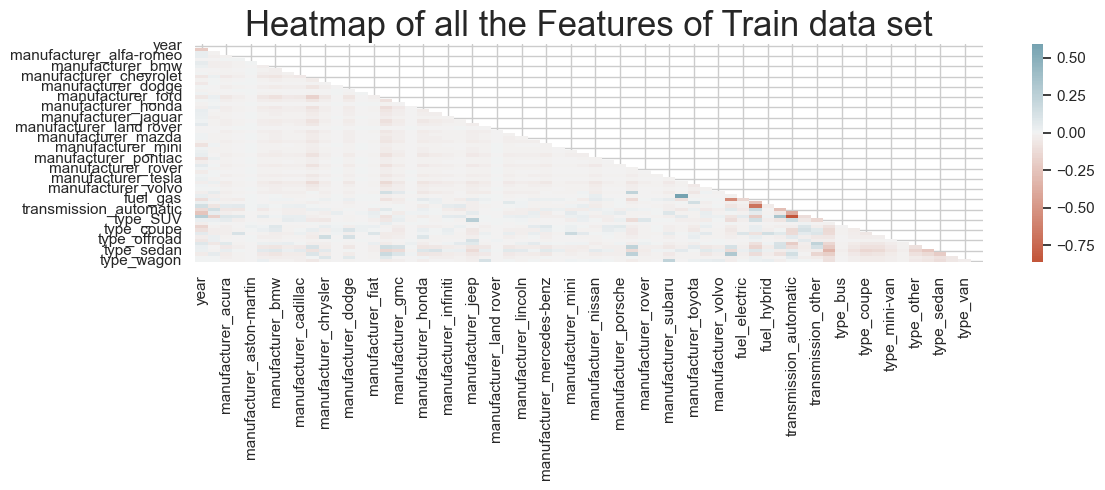

In [40]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (12,5))
## Plotting heatmap. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(X_train.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X_train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=False, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);
plt.tight_layout()
plt.savefig('images/heatmap')
plt.show('jpg')

#### The heatmap does not show any clear correlatory effects

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Here are some high level observations

- Maximum sales happen for the lower priced cars. The 75th percentile is at $25990
- The average odometer reading is about 98000 miles
- There is more sales on newer cars. This may be due to higher inventory of such cars
- There are no clear patterns for regions. Certain regions have more sale than others.
- Ford, Toyota and chevrolet are popular manufacturers
- Gas cars are more popular than other types
- Lower odometer cars are more preferred
- Automatic transmission seems to be the preferred choice
- Sedans, SUV, followed by pickups have the highest sale over other types.
- Among the newer cars the 'other' type appears to be the dominant type.
- Among the newer cars, the pickups and trucks seem be higher priced
- Manual transmission seems be the majority of the sales
- Manual transmission has a lower average price than Automatic transmission at all times.
- The median price of newer cars are in general higher. There is some anamoly for 2022 year cars.
- There is a larger variation in the price for newer cars
- Van and pickup pricess are higher in general than other types

#### The features the most contribute to the price changing are
- Year of the car
- Sedan type
- Pickup type
- Other transmission type
- Truck type
- Odometer value

#### The following Manufactures contribute to maximum lowering of the price (in the order listed)

  * Manufacturer ferrari
  * Manufacturer Harley Davidson
  * Manufacturer Fiat
  * Manufacturer Saturn
  
#### Conclusion: Stocking Ferrri, Harley, Fiat or Saturn may not be very good for the dealership

  
#### The following predictors drive price up (in the order listed below)

  * Manufacturer Tesla
  * Manufacturer Datsun
  * Manufacturer Porsche
  * Manufacturer Rover
  * Type Pickup
  
#### Conclusion: Stocking Tesla, Datsun, Porsche, rover and any Pickup type cars in general is good for the dealership as it drives price up and could make be more profitable.
